## Layered Sigma Clipped, Part 2
-------
Created by Dr. Taylor Hutchison, NASA GSFC,  
on behalf of the TEMPLATES team.


This is the second step in the sigma clipping part of the algorithm described in H+, section 2.2.2.  In this step, we use a layered sigma cliping process on the science target spaxels in the IFU cube, saving the output to its own FITS file to be read in at the final step.

<div class="alert alert-success">
    <b>NOTE</b> -- this step will likely be the most hands-on of the entire algorithm.  As described in H+, some adjustement may be needed between this step and the part of the mask making code where you define the S/N layers for your science target (generally, this just means shifting the S/N ranges for each layer and rerunning this step to see how it changed).
</div>

In [1]:
from routines import * # helper functions & the needed imports

### Defining values

Below, we'll set some predefined information for the science target.

In [2]:
# --------------------------
# SCIENCE TARGET INFORMATION
# --------------------------
target = 'SGAS1723' # science target name

# returns dictionary of info for chosen science target
# also path to reduced FITS cubes to read in
science_target, path, grating = get_target_info(target)

# target-specific information
filename = science_target['grating'][grating]['filename']
sli = science_target['grating'][grating]['slice-target'] # benchmark slice index (diff than part 1)


# for the sigma clipping part
# ---------------------------
sigma = 5
maxiters = 5


In [3]:
# defining a save path for the output data
# savepath = 'path/to/outputs'
savepath = 'plots-data/'


# checking if savepath locatiion existis
# if not, creating the folder 
if os.path.exists(savepath) == False: # if folder doesn't exist
    print('Creating folder ' + savepath)
    os.system('mkdir ' + savepath) # creates the folder

In [4]:
# ---------------------
# reading in data cubes
# ---------------------
datacube, header = fits.getdata(path+filename, header=True) 
errorcube = fits.getdata(path+filename, ext=2) 

benchmark_slice = datacube[sli]

### Defining the benchmark spaxels

Here we'll define the four spaxels that we'll reference throughout this notebook.  You can pre-identify these spaxels by inspecting the data cube using a software like ds9 (however, if you do this, recall that ds9 indexes beginning at 1 while python beings at 0).

Feel free to re-run the following cell over again as you change the spaxel coordinates, until you find four that you like.

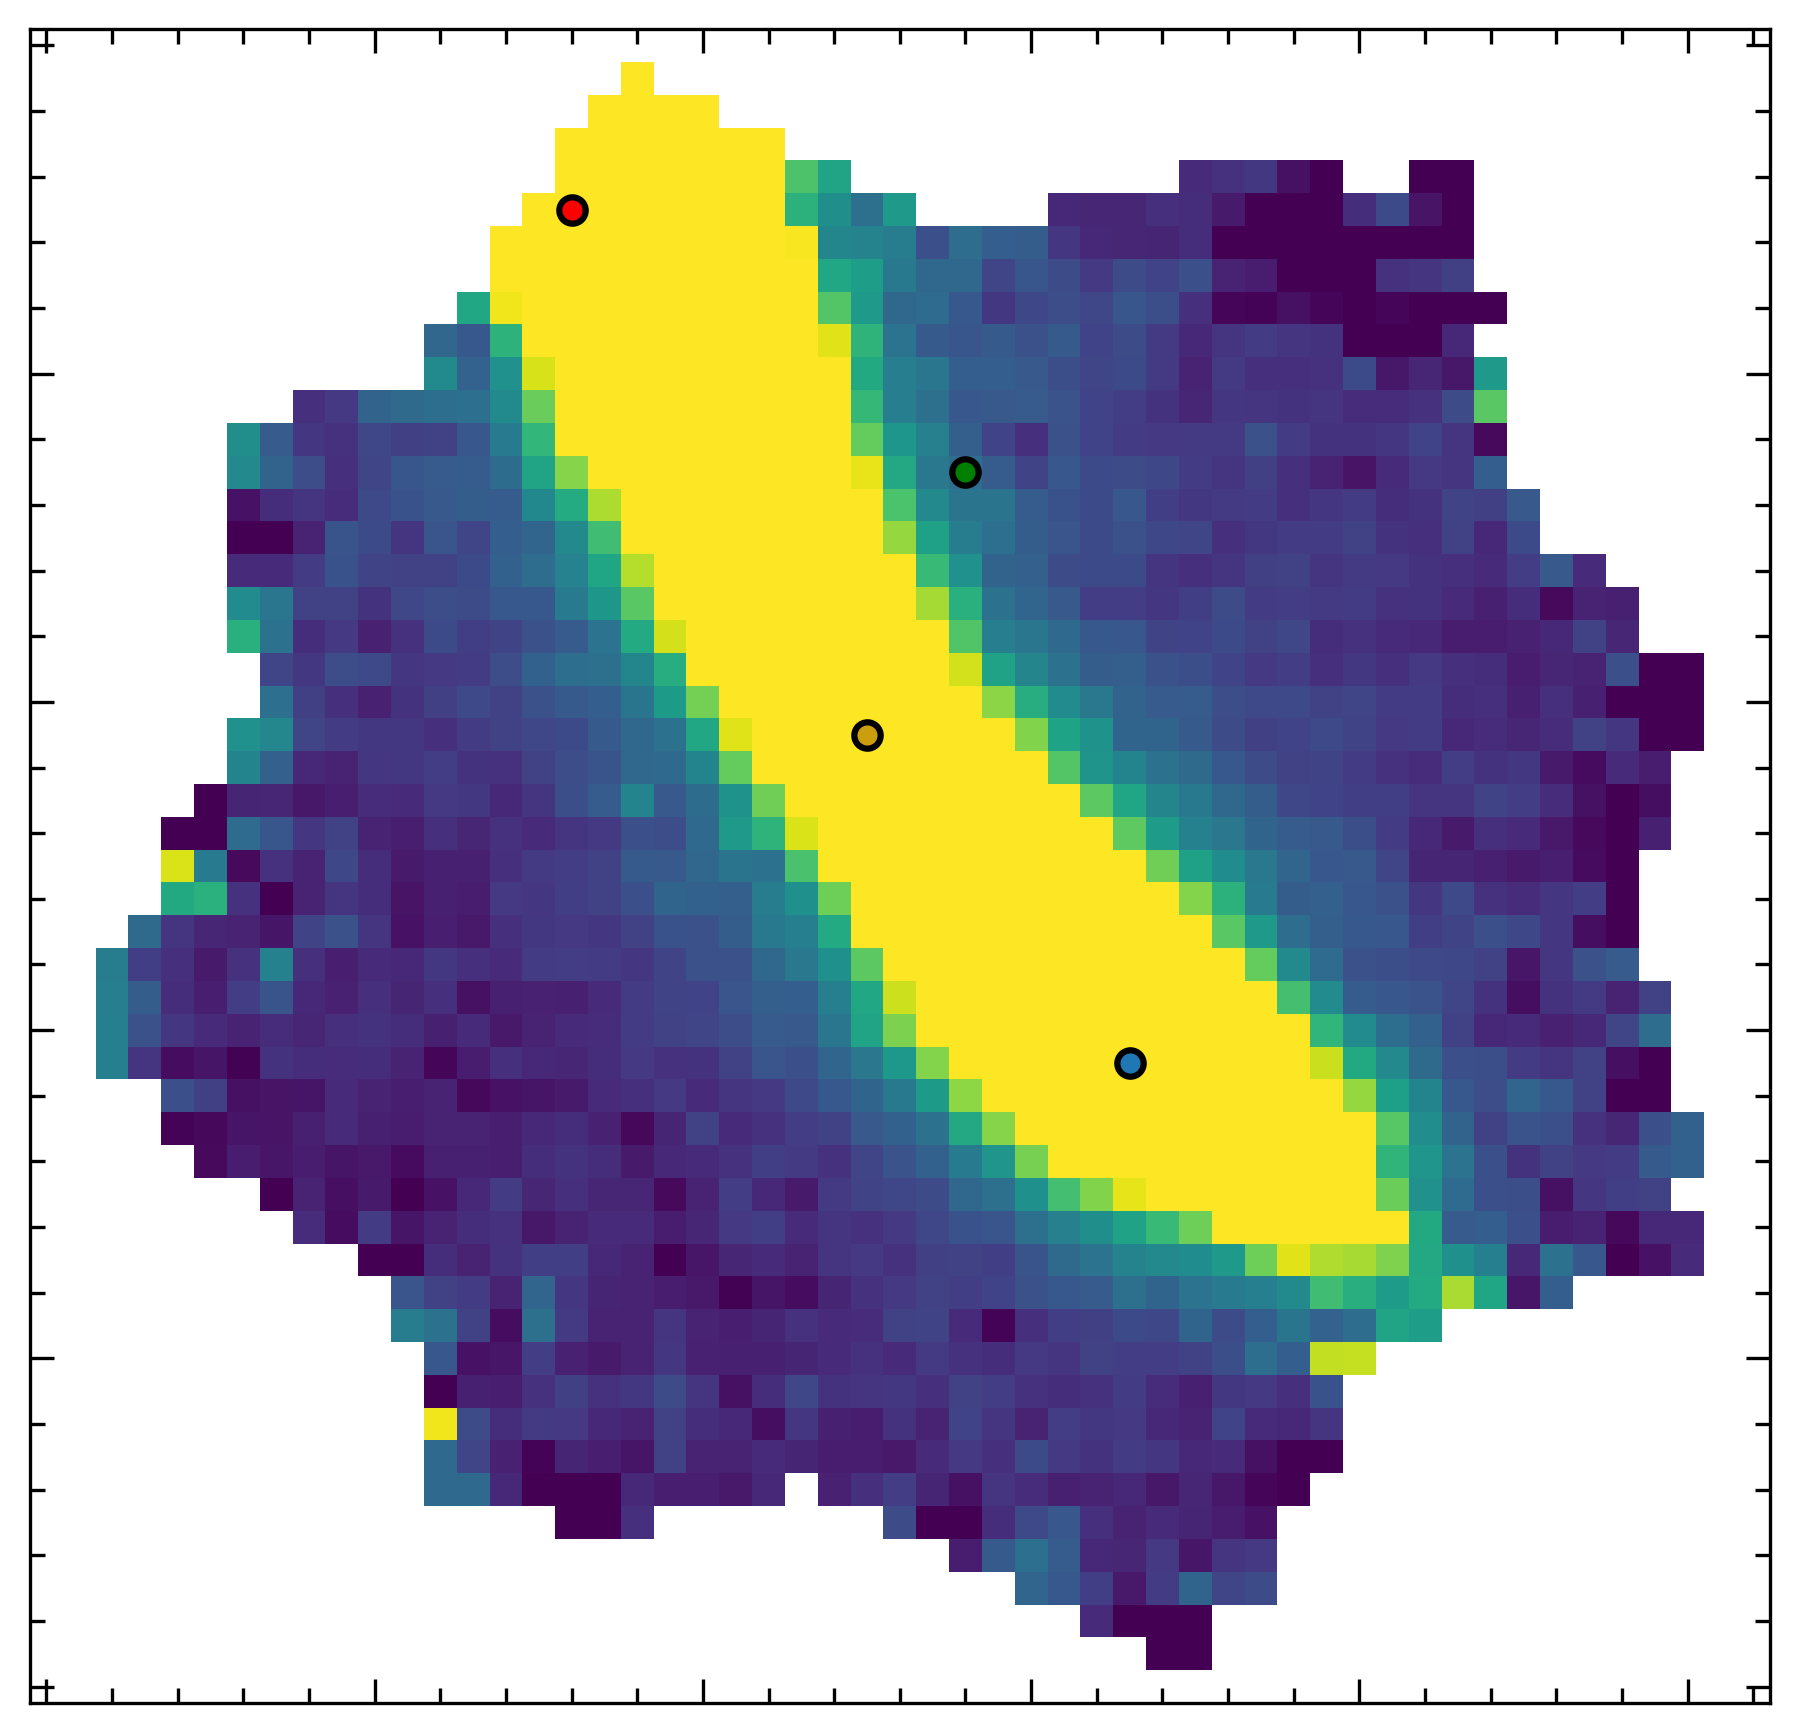

In [5]:
# identifying benchmark spaxels to look at throughout the sigma clipping process

x,y = 33,19 # spaxel 1, make this one "normal"
x2,y2 = 28,37 # spaxel 2
x3,y3 = 25,29 # spaxel 3
x4,y4 = 16,45 # spaxle 4

# LOOKING AT THE BENCHMARK SLICE & LOCATION OF 
# BENCHMARK SPAXELS CHOSEN ABOVE
# ---------------

# defining the colormap limits here, will use throughout notebook
clims = (-0.5,5)


plt.figure(figsize=(8,6))

plt.imshow(benchmark_slice,clim=clims,origin='lower',cmap='viridis')

plt.scatter(x,y,s=40,edgecolor='k',color='C0',lw=1.5) # "normal" spaxel
plt.scatter(x2,y2,s=40,edgecolor='k',color='g',lw=1.5) # spaxel 2
plt.scatter(x3,y3,s=40,edgecolor='k',color='#CB9E0E',lw=1.5) # spaxel 3
plt.scatter(x4,y4,s=40,edgecolor='k',color='r',lw=1.5) # spaxel 4

plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

plt.tight_layout()
plt.show()
plt.close('all')


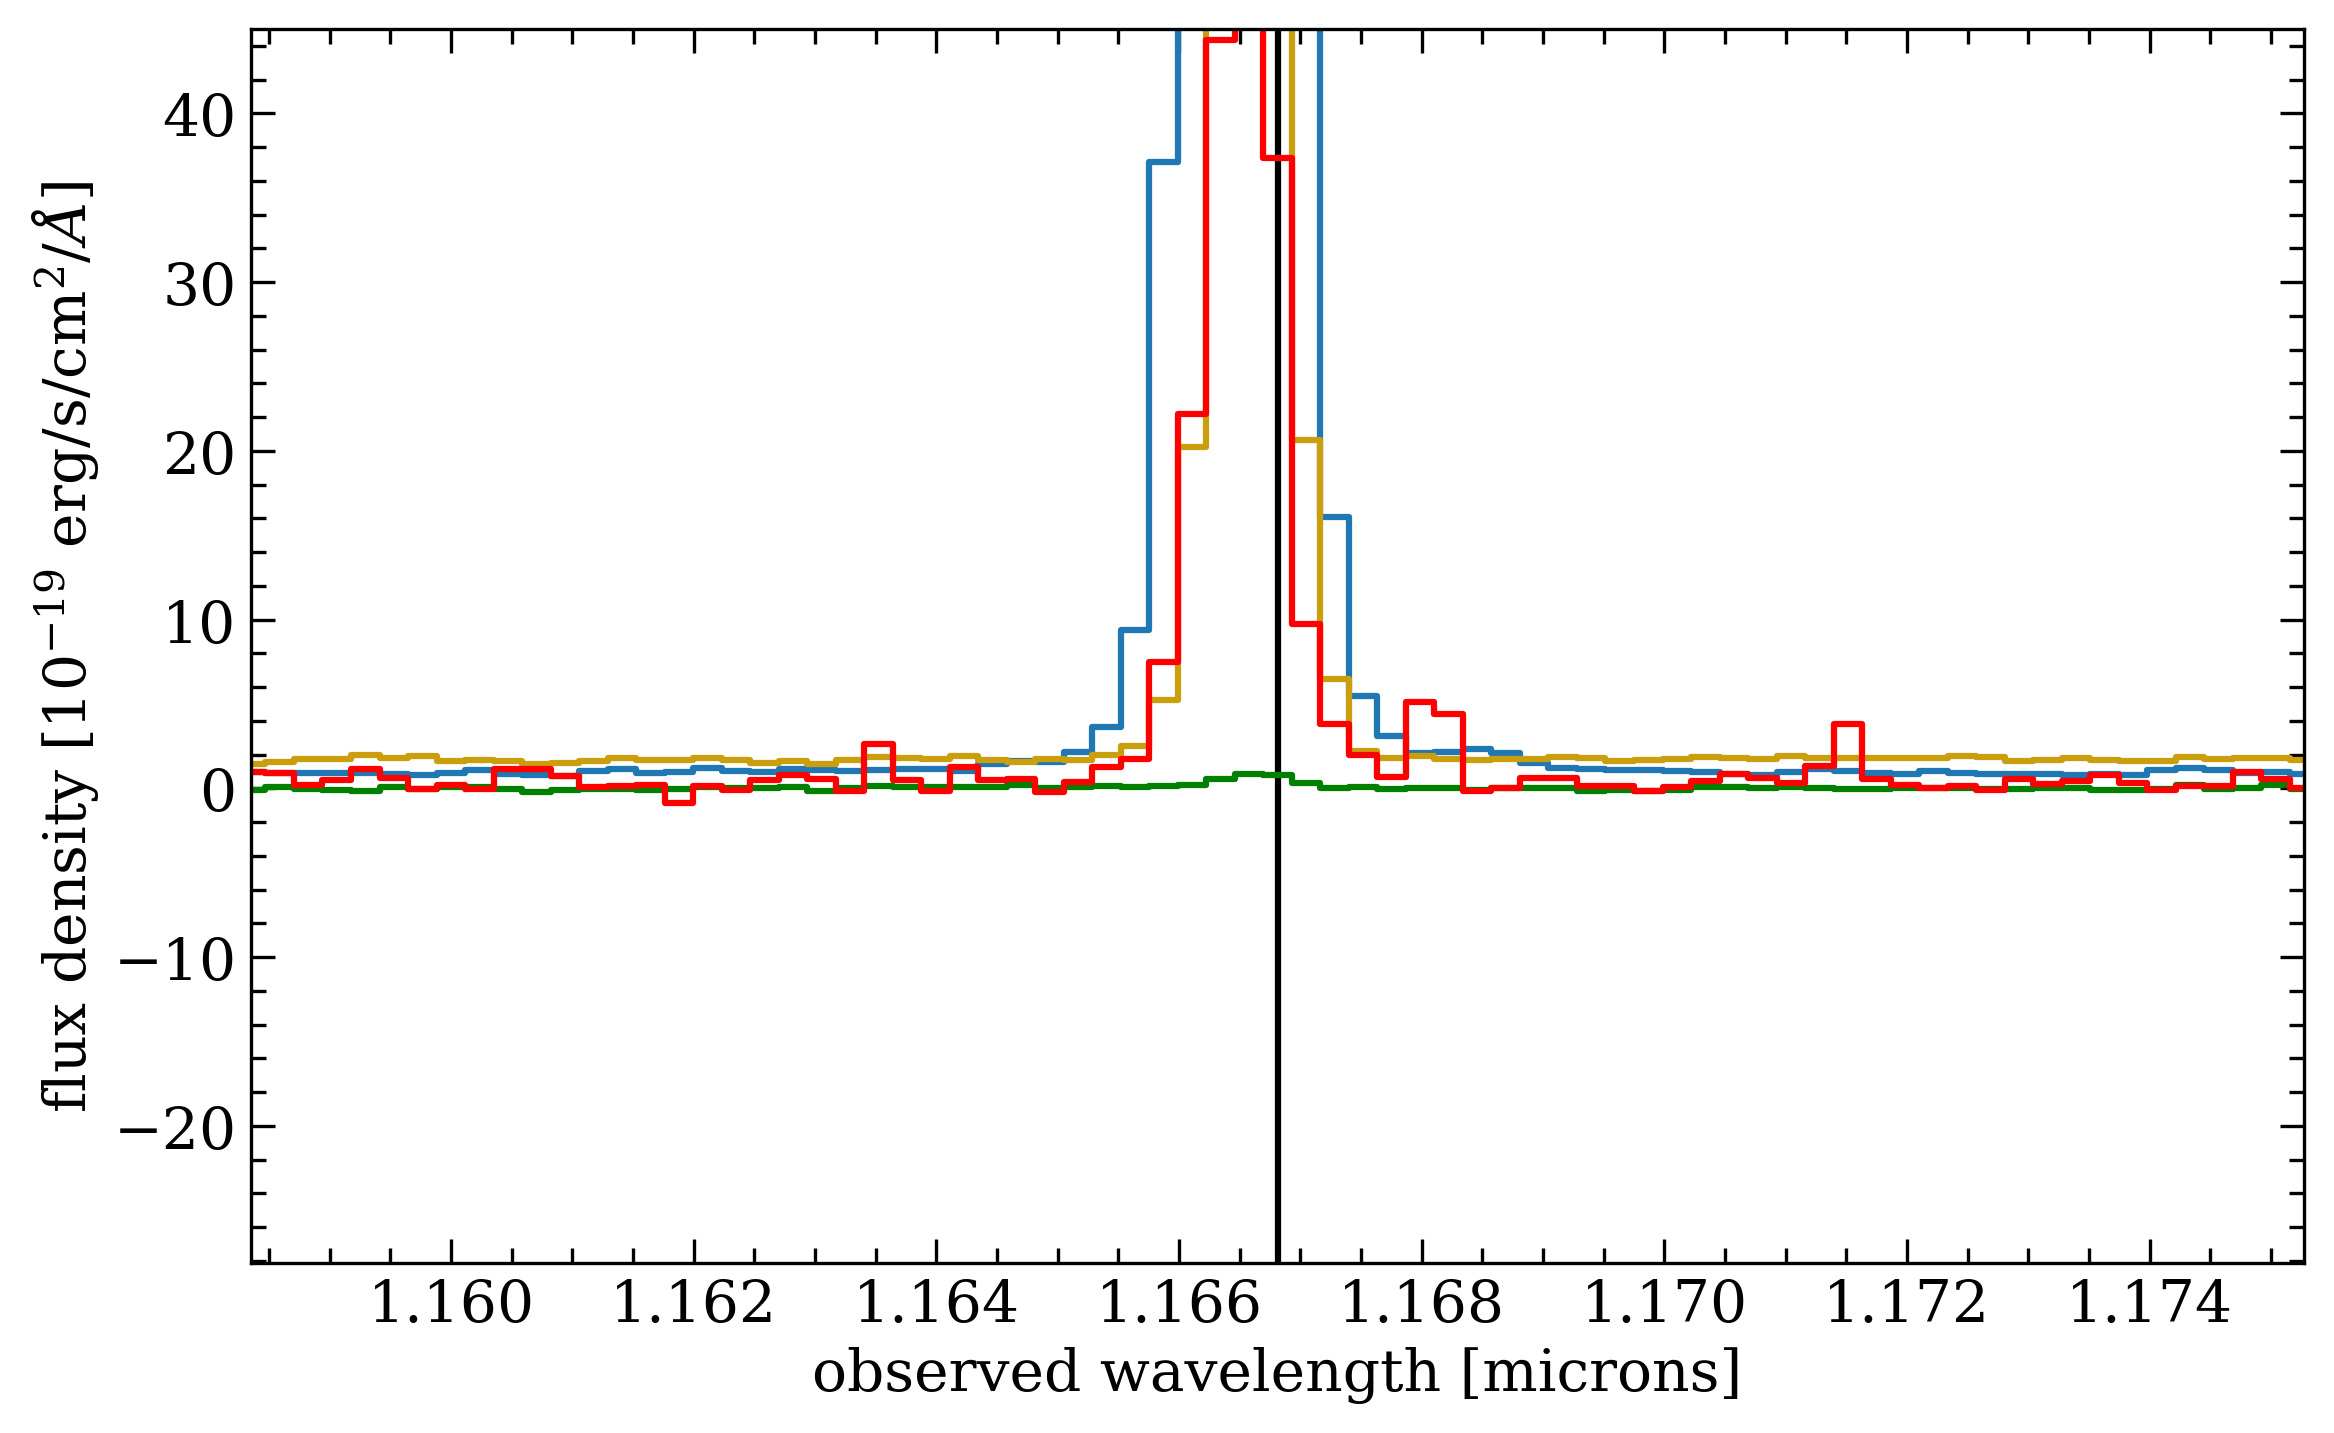

In [6]:
# ------------------------------------------
# LOOKING AT 1D AROUND BENCHMARK SLICE IN 1D
# ------------------------------------------

wave_mask = get_benchmark_wave_index(datacube,sli,header) # indicies around benchmark slice

# pulling spectrum at each benchmark spaxel
spec = get_spec(x,y,datacube,errorcube,header)
spec2 = get_spec(x2,y2,datacube,errorcube,header)
spec3 = get_spec(x3,y3,datacube,errorcube,header)
spec4 = get_spec(x4,y4,datacube,errorcube,header)

scale = get_yaxis_scaling(spec.flam.values) # to scale yaxis for readability
benchmark_wave = spec.loc[sli,'wave'] # to mark the benchmark slice in 1D

plt.figure(figsize=(8,5))

plt.step(spec.wave,spec.flam/scale,where='mid')
plt.axvline(benchmark_wave,color='k')

plt.step(spec2.wave,spec2.flam/scale,where='mid',color='g')
plt.step(spec3.wave,spec3.flam/scale,where='mid',color='#CB9E0E')
plt.step(spec4.wave,spec4.flam/scale,where='mid',color='r')

plt.xlim(spec.loc[wave_mask[0],'wave'],spec.loc[wave_mask[-1],'wave'])
plt.xlabel('observed wavelength [microns]')
plt.ylabel('flux density [10$^{%s}$ erg/s/cm$^2$/$\AA$]'%int(np.log10(scale)))

# roughhand setting of ylimits to not be biased by false signal;
# so that real features are visible in this validation check
y_scale = abs(np.nanmean([spec2.median().flam,spec3.median().flam,spec4.median().flam]) / scale)
plt.ylim(-50*y_scale,80*y_scale)


plt.tight_layout()
plt.show()
plt.close('all')


<div class="alert alert-success">
    We'll heavily lean on the before and after spectra of the benchmark spaxels to check that the code is functioning as it should. 
</div>

### Reading in mask information

For this step in the layered sigma clipping algorithm, we use both the main mask (that simply defines if a spaxel is associated with the science target or not) AND the mask layers.

In [7]:
mask, mask_info = get_mask(target)
full_mask = mask[0].copy() # first entry is the full mask, rest are the layers

masked_benchmark_slice = benchmark_slice.copy()
masked_benchmark_slice[full_mask<1] = np.nan

### Initial layered sigma clipping test using benchmark slice

Similar to this step in Part 1, we'll run the clipping on just the benchmark slice, before moving to running it on every slice in the cube.  However, the difference here is that we'll be running the sigma clipping on the individual layers of the science target mask -- where each layer represents a range in S/N for the science target.

As before, the left panel is the original benchmark slice, while the right panel is the same slice after clipping.  Any pixels flagged in the clipping will be NaNs (white).

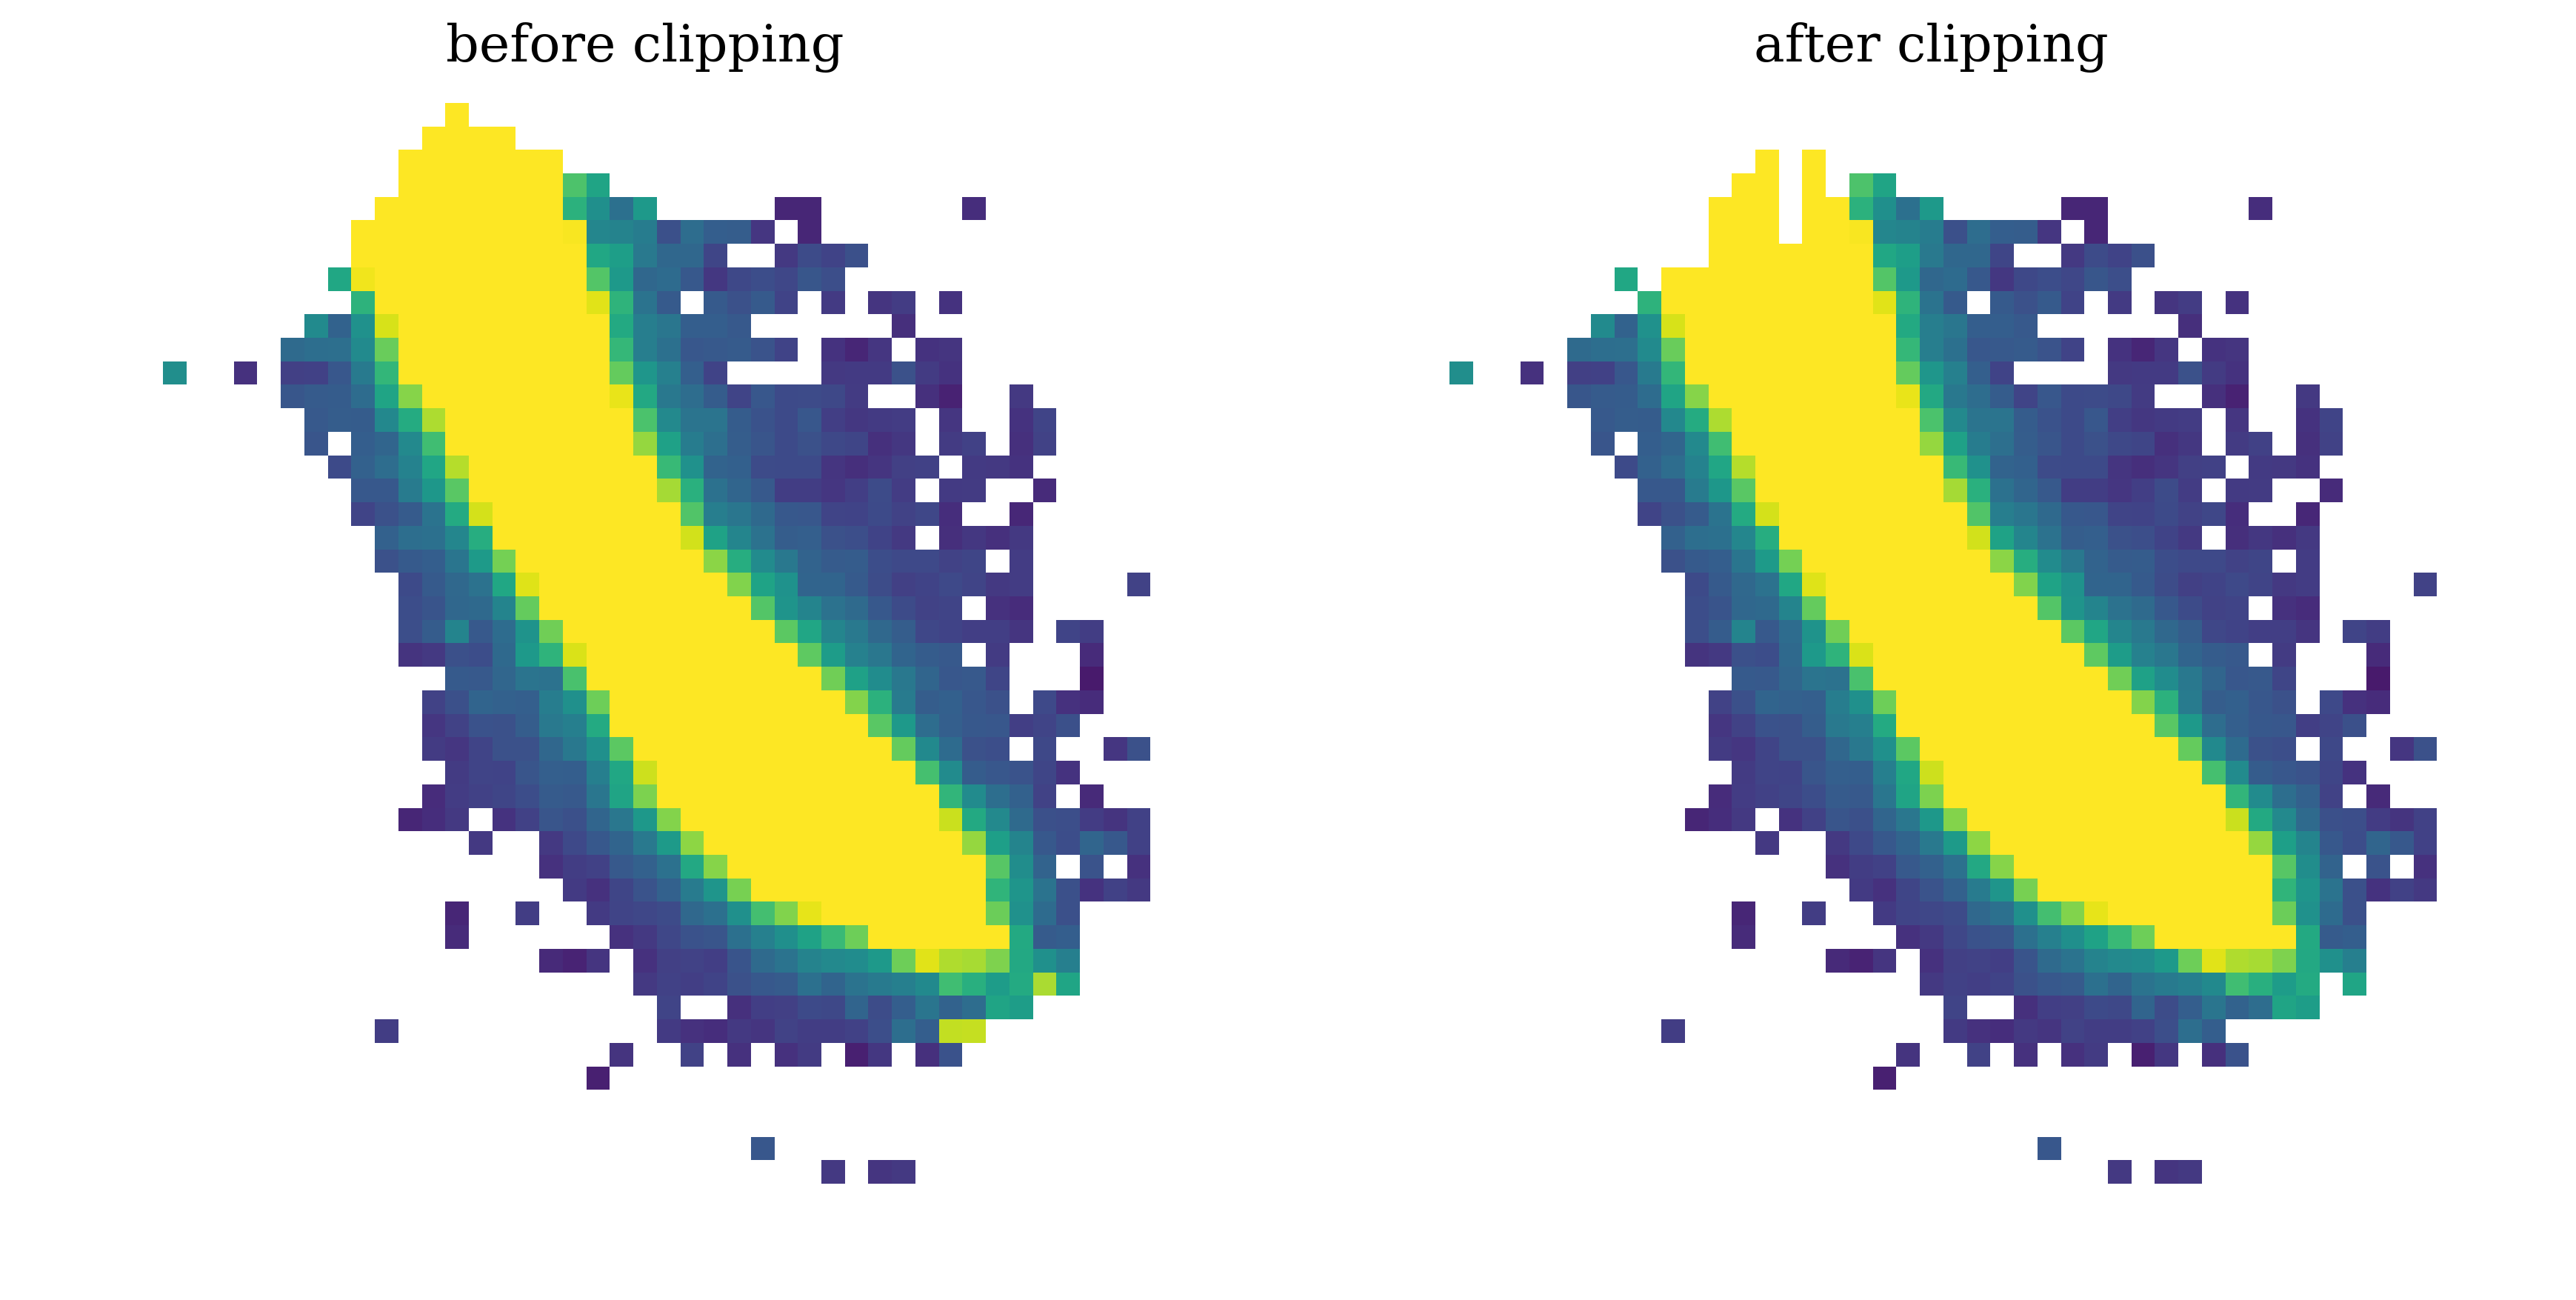

In [8]:
# sigma clipping masked slice layers one at a time
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    
    clipped_layers, clipped_layers_err = [], []
    for i in range(len(mask)-1):
        # data
        masked_slice_layer = masked_benchmark_slice.copy()
        masked_slice_layer[mask[i+1]<1] = np.nan # one layer at a time
        
        clip_mask = sigma_clip(masked_slice_layer, sigma=sigma, maxiters=5).mask
        
        # data
        masked_slice_layer[clip_mask] = np.nan
        clipped_layers.append(masked_slice_layer)


# setting up the final slice, starting with NaNs & then adding each layer
clipped_benchmark_slice = np.zeros(mask[0].shape)
clipped_benchmark_slice[:] = np.nan

# adding the clipped layers one by one
for i in range(len(clipped_layers)):
    clipped_benchmark_slice[mask[i+1]>0] = clipped_layers[i][mask[i+1]>0].copy()

        


# plotting clipped benchmark slice
# --------------------------------

plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2,width_ratios=[1,1],wspace=0)

ax = plt.subplot(gs[0]); ax.axis('off'); ax.set_title('before clipping')
ax.imshow(masked_benchmark_slice,clim=clims,origin='lower',cmap='viridis')

ax = plt.subplot(gs[1]); ax.axis('off'); ax.set_title('after clipping')
ax.imshow(clipped_benchmark_slice,clim=clims,origin='lower',cmap='viridis')


plt.tight_layout()
plt.show()
plt.close('all')


### Running on the full cube

Assuming nothing went horribly wrong with the previous step, we'll move to running this layered clipping procedure on the entire cube, for all of the science target spaxels.

In [9]:
# ----------------------
# RUNNING SLICE-BY-SLICE
# ----------------------

# making cube of zeros to log when a pixel has been clipped
clipped_pixels = np.zeros(datacube.shape) # will be 1 in slice if pixel is clipped


# clipping slices based on S/N contours previously defined
data_clipped = datacube.copy()
error_clipped = errorcube.copy()

for s in range(len(data_clipped)):
    data_slice = datacube[s].copy()
    error_slice = errorcube[s].copy()

    # first, masking out sky spaxels
    data_slice[full_mask<1] = np.nan
    error_slice[full_mask<1] = np.nan
    
    mask_data_slice = data_slice.copy()
    mask_error_slice = error_slice.copy()
    
    # marking the pixels that were nans before
    # due to rotation of IFU based on observing PA
    nans_before = np.zeros(mask_data_slice.shape)
    nans_before[np.isnan(mask_data_slice) == True] = 1
    
    # first checking for the all-NaN slices in IFU
    # if yes, nothing happens for that slice and it just
    # gets added to the final cube as is
    # (this check is a holdover from earlier jwst pipeline versions)
    if np.isnan(mask_data_slice).all() == False:
        
        # sigma clipping masked slice layers one at a time
        with warnings.catch_warnings():  # Ignore warnings
            warnings.simplefilter('ignore')

            clipped_layers,clipped_layers_error = [],[]
            clipped_pixels_layers = []
            
            for j in range(len(mask)-1):
                
                # setting up slice and layer
                masked_slice_layer = mask_data_slice.copy()
                masked_slice_layer[mask[j+1]<1] = np.nan # one layer at a time

                # for the error, too
                masked_slice_layer_error = mask_error_slice.copy()
                masked_slice_layer_error[mask[j+1]<1] = np.nan # one layer at a time
                
                # for the clipped pixel tracker, too
                masked_clipped_pixels = np.zeros(masked_slice_layer.shape)

                # sigma clipped LAYER in slice
                clip_mask = sigma_clip(masked_slice_layer, sigma=sigma, maxiters=5).mask

                # replaced flagged things in LAYER with nanmedian
                masked_slice_layer[clip_mask] = np.nanmedian(masked_slice_layer)
                masked_slice_layer_error[clip_mask] = np.nanmedian(masked_slice_layer_error)

                # logging pixels that were clipped in separate cube
                masked_clipped_pixels[clip_mask] = 1
                # removing pixels that were NaNs before
                masked_clipped_pixels[mask[j+1]<1] = 0
                
                # re-masking the rest
                masked_slice_layer[mask[j+1]<1] = np.nan # one layer at a time
                masked_slice_layer_error[mask[j+1]<1] = np.nan # one layer at a time

                clipped_layers.append(masked_slice_layer)
                clipped_layers_error.append(masked_slice_layer_error)
                clipped_pixels_layers.append(masked_clipped_pixels)


            # making one fully clipped view to see if it works/how it's working
            # starting with NaNs & then will add each layer
            masked_slice_clipped = np.zeros(full_mask.shape)
            masked_slice_clipped[:] = np.nan

            masked_slice_clipped_error = np.zeros(full_mask.shape)
            masked_slice_clipped_error[:] = np.nan
            
            # adding the clipped layers one by one
            for i in range(len(clipped_layers)):
                masked_slice_clipped[mask[i+1]>0] = clipped_layers[i][mask[i+1]>0].copy()
                masked_slice_clipped_error[mask[i+1]>0] = clipped_layers_error[i][mask[i+1]>0].copy()
                clipped_pixels[s][mask[i+1]>0] = clipped_pixels_layers[i][mask[i+1]>0].copy()

            # adding back in nans that were there before
            masked_slice_clipped[nans_before == 1] = np.nan
            masked_slice_clipped_error[nans_before == 1] = np.nan
            
            # for clipping tracking, removing pixels that were NaNs before
            clipped_pixels[s][nans_before == 1] = 0
                
        # clipped-by-layer slice added to final cube; rinse & repeat
        data_clipped[s] = masked_slice_clipped.copy()
        error_clipped[s] = masked_slice_clipped_error.copy()

        
# verifying everything has the dimensions that they should at the end
print(datacube.shape,data_clipped.shape)

(3915, 51, 53) (3915, 51, 53)


### Checking changes in benchmark spaxels

As mentioned above, use the following plot of the benchmark spaxels' spectra to compare the before & after of the clipping process.  This will be one of the most useful checks in this step of the algorithm -- it will be very clear if something needs to be adjusted.  Here are some things you can look for:

- If a benchmark spaxel was near the edge of the IFU field of view, check that the flux density & shape of the spectral feature you're centered on hasn't dropped in value significantly -- as if it was fully replaced by lower S/N values.  If so, that spaxel needs to be moved to a higher S/N mask layer manually because it is being continually clipped in the layer it's currently in.
- If you see the peak of the spectral feature (e.g., an emission line) partially clipped for one of your benchmark spaxels, either 1) move the spaxel to a higher S/N mask layer or 2) play with changing the S/N ranges for each mask layer so that there's not so large a S/N range in that mask layer (see Section 2.1.3 and 2.2.2 in H+ for more discussion on this).

<div class="alert alert-success">
    Note in the example galaxy used in this notebook (if you've cleared the output already, check the online version to see the images) that the top corner gets clipped in the 2D example above.  In the same way, notice how the red benchmark pixel spectrum below is now much lower.  This is an example of the first bullet point above, where these pixels are near the edge of the IFU field of view -- therefore their S/N is "lower" but the values themselves are much higher (and we know that they are real, not artificially-high values).
</div>

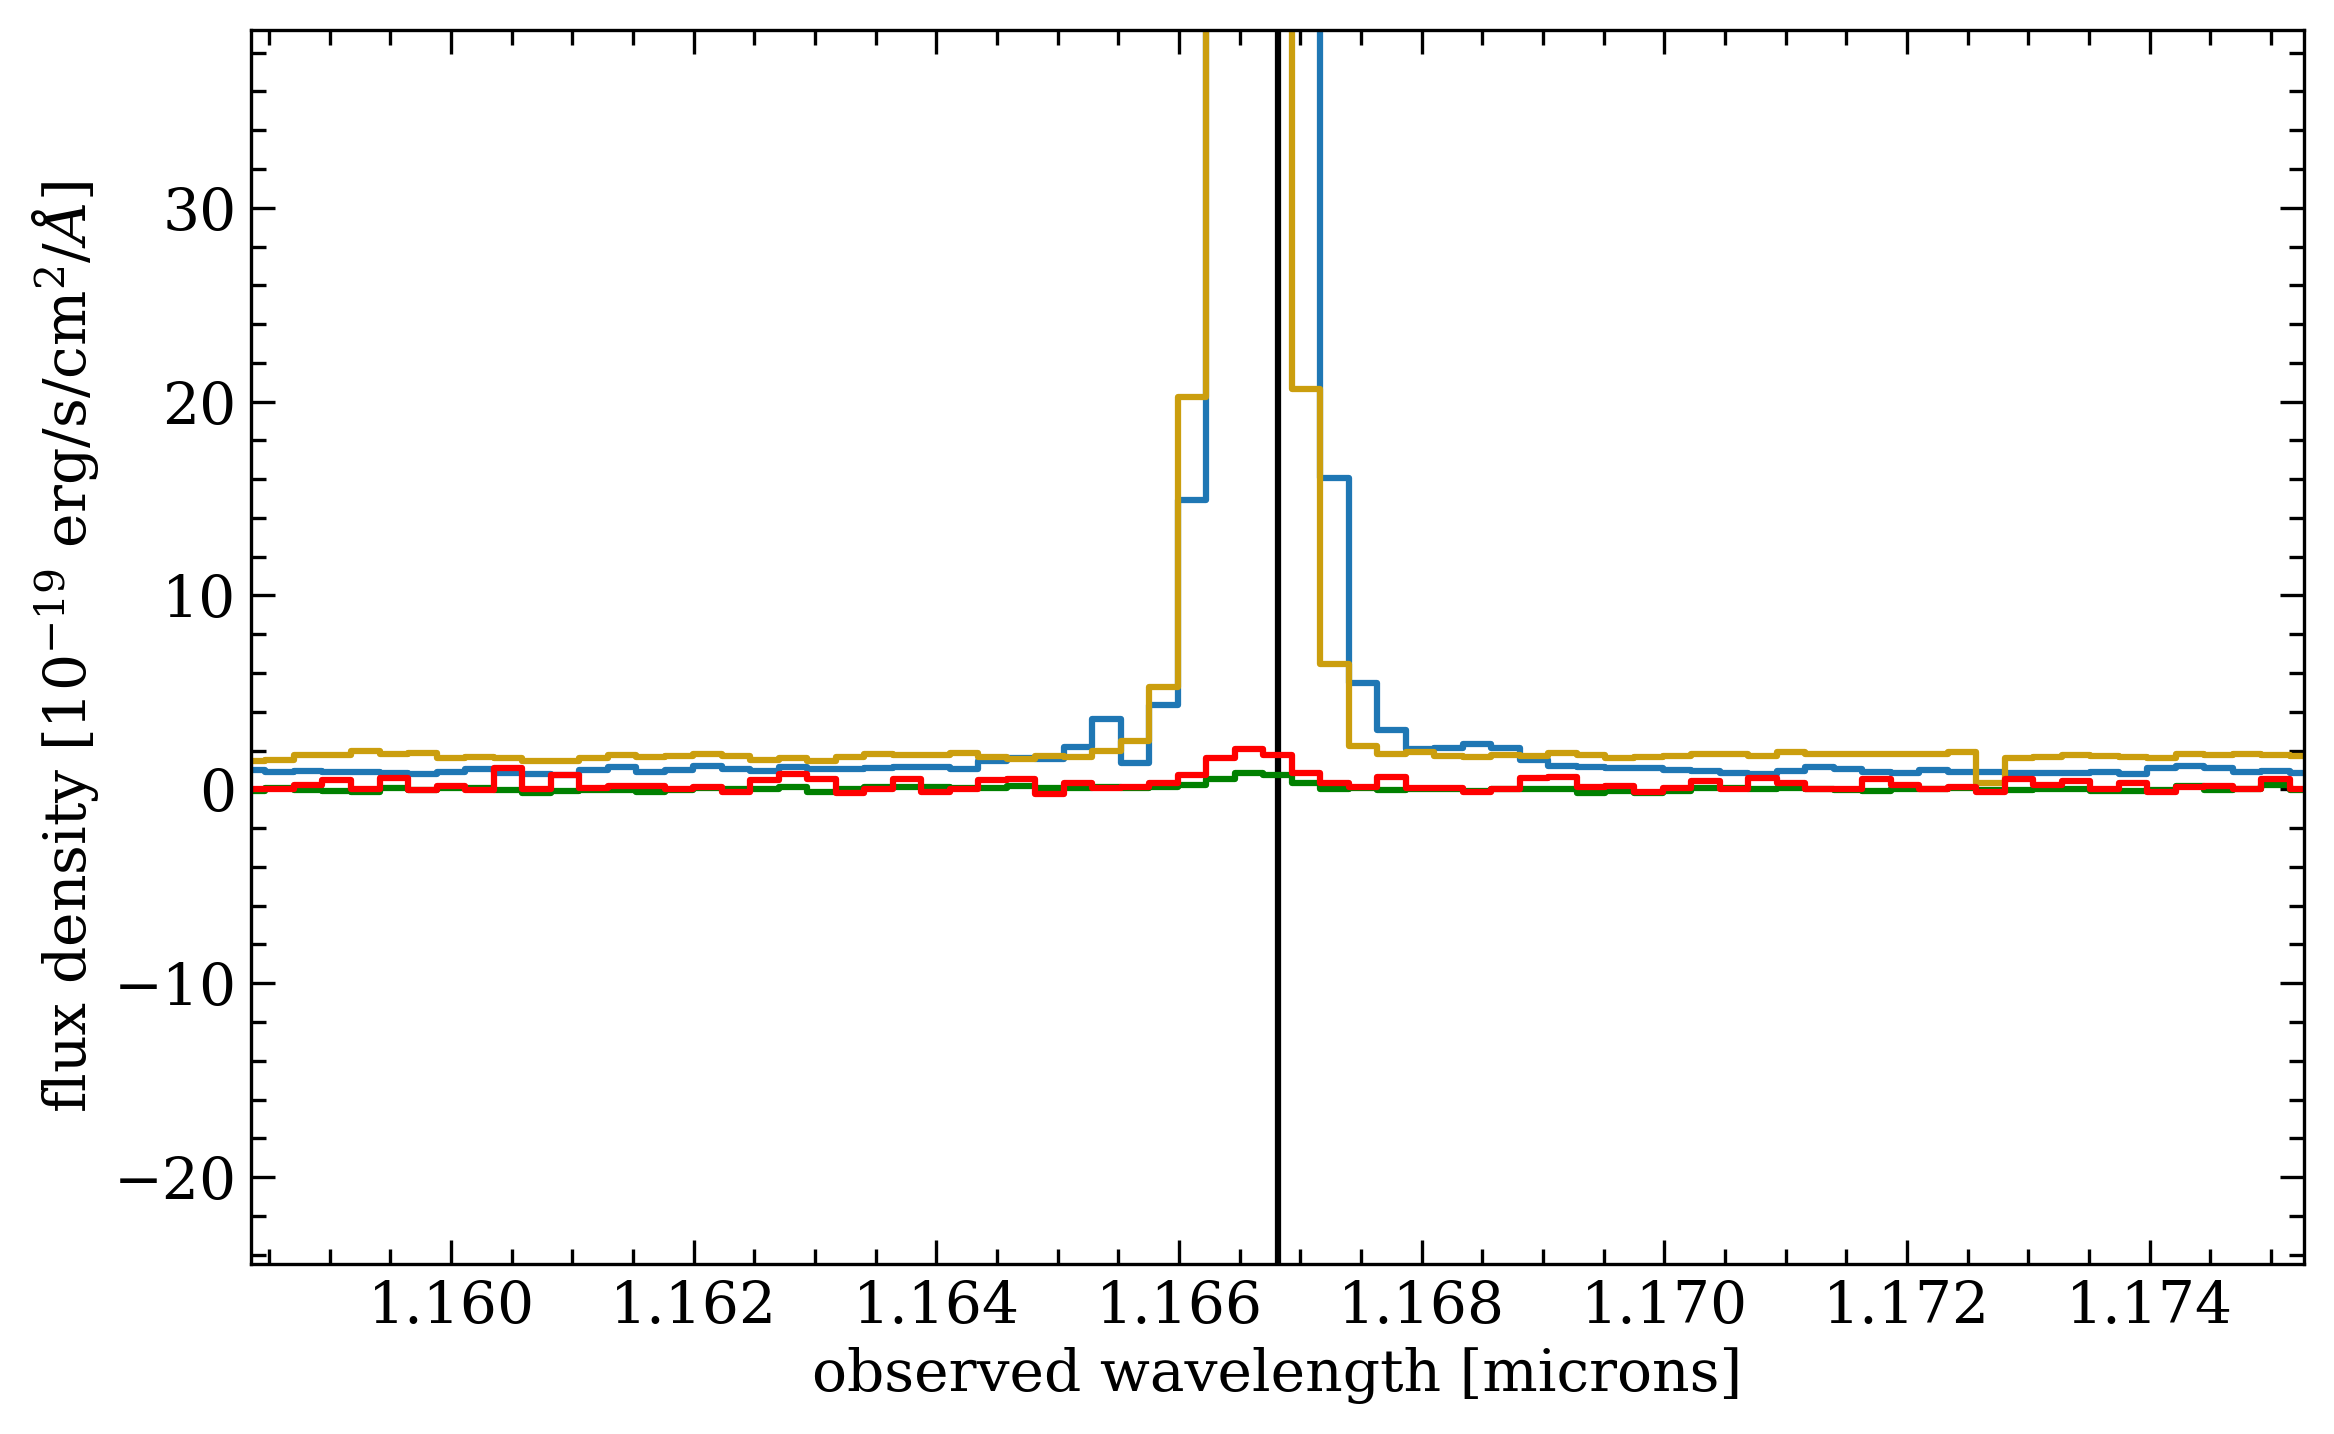

In [10]:
# ------------------------------------------
# LOOKING AT 1D AROUND BENCHMARK SLICE IN 1D
# ------------------------------------------

wave_mask = get_benchmark_wave_index(datacube,sli,header) # indicies around benchmark slice

# pulling spectrum at each benchmark spaxel, in clipped data & error cubes
spec = get_spec(x,y,data_clipped,error_clipped,header)
spec2 = get_spec(x2,y2,data_clipped,error_clipped,header)
spec3 = get_spec(x3,y3,data_clipped,error_clipped,header)
spec4 = get_spec(x4,y4,data_clipped,error_clipped,header)

scale = get_yaxis_scaling(spec.flam.values) # to scale yaxis for readability
benchmark_wave = spec.loc[sli,'wave'] # to mark the benchmark slice in 1D

plt.figure(figsize=(8,5))

plt.step(spec.wave,spec.flam/scale,where='mid')
plt.axvline(benchmark_wave,color='k')

plt.step(spec2.wave,spec2.flam/scale,where='mid',color='g')
plt.step(spec3.wave,spec3.flam/scale,where='mid',color='#CB9E0E')
plt.step(spec4.wave,spec4.flam/scale,where='mid',color='r')

plt.xlim(spec.loc[wave_mask[0],'wave'],spec.loc[wave_mask[-1],'wave'])
plt.xlabel('observed wavelength [microns]')
plt.ylabel('flux density [10$^{%s}$ erg/s/cm$^2$/$\AA$]'%int(np.log10(scale)))

# roughhand setting of ylimits to not be biased by false signal;
# so that real features are visible in this validation check
y_scale = abs(np.nanmean([spec2.median().flam,spec3.median().flam,spec4.median().flam]) / scale)
plt.ylim(-50*y_scale,80*y_scale)


plt.tight_layout()
plt.show()
plt.close('all')


<div class="alert alert-success">
    Check out the <b>troubleshooting_visually.py</b> helper plotting functions if you want more ways to explore the data before and after the layered sigam clipping step -- they include functions to plot IFU slices, find spaxels, plot spaxel spectra, etc.
</div>

### Saving outputs!

As we're running this algorithm piecewise -- first the sky spaxels in this notebook, then the science target spaxels in the next notebook -- we'll save the outputs from this notebook in a subfolder.  If it doesn't exit yet, no worries!  We'll make the subfolder, too.

In [11]:
# checking that the file system is in place for these data
# if not, creating the folder for saving the part 1 & part 2 pieces

if os.path.exists(savepath + 'sigma-clipping-pieces/') == False: # if folder doesn't exist
    print('Creating folder ' + output_path + 'sigma-clipping-pieces/')
    os.system('mkdir ' + output_path + 'sigma-clipping-pieces/') # creates the folder

For now, we're using a quick-and-dirty method to preserve the important header info -- copying the original header to these new cubes that we're saving and adding a comment.  This will be updated to a more accurate header in later versions.

In [12]:
header['comment'] = 'science target spaxels sigma-clipped by H+ algorithm'

pieces_path = savepath + 'sigma-clipping-pieces/'

hdu = fits.PrimaryHDU(header=header)
hdu1 = fits.ImageHDU(data_clipped,header=header) # the data cube
hdu2 = fits.ImageHDU(error_clipped,header=header) # the error cube
hdu3 = fits.ImageHDU(clipped_pixels,header=header) # the clipped pixels logging
hdul = fits.HDUList([hdu, hdu1, hdu2, hdu3])
hdul.writeto(f'{pieces_path}/{target}-sigmaclipping-target-{grating}-s3d.fits',overwrite=True)
    

### Double-check 
At this point, make sure to double-check that the layered clipping process is working as it should.  It may require you to adjust the S/N ranges in the mask layer defining step.

.  
.  
.  
### All good?  Next notebook...